# Time Series Sales Forecasting for Supermarkets Using XGBoost
# Market Maven project

## 1. Setup and Installation
- **Install Required Packages**

In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.5 MB/s eta 0:00:00


## 2. Import Libraries
- Libraries used for data processing, modeling, and visualization:
  - `pandas`, `numpy`, `xgboost`, `sklearn`, `optuna`, etc.

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import optuna
import joblib
import matplotlib.pyplot as plt
from scipy.stats import boxcox

## 3. Load and Preprocess Data
### 3.1 Load Dataset
- Load `supermarket_sales.csv`.
- Ensure required columns (`Date` and `Total`) exist.

In [3]:
# Load data
data = pd.read_csv('supermarket_sales.csv')

# Ensure required columns exist
required_columns = ['Date', 'Total']
for col in required_columns:
    if col not in data.columns:
        raise KeyError(f"The input data must contain '{col}' column.")

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

### 3.2 Feature Engineering
- Add temporal features (`Day`, `Month`, `Year`, `WeekOfYear`, `DayOfWeek`).
- Create cyclical features (`Sin_DayofYear`, `Cos_DayofYear`).
- Generate lag and rolling features.

In [4]:
# Feature Engineering
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year
data['WeekOfYear'] = data.index.isocalendar().week.astype(int)
data['DayOfWeek'] = data.index.dayofweek

data['Sin_DayofYear'] = np.sin(2 * np.pi * data.index.dayofyear / 365)
data['Cos_DayofYear'] = np.cos(2 * np.pi * data.index.dayofyear / 365)

# Lag and Rolling Features
data['Lag_Total_1'] = data['Total'].shift(1)
data['Lag_Total_7'] = data['Total'].shift(7)
data['Lag_Total_30'] = data['Total'].shift(30)
data['Rolling_Mean_7'] = data['Total'].rolling(window=7).mean()
data['Rolling_Mean_30'] = data['Total'].rolling(window=30).mean()
data['EMA_Total'] = data['Total'].ewm(span=10).mean()

### 3.3 Encode Categorical Variables
- Apply one-hot encoding to categorical variables.
- Drop unnecessary columns and NaN values.
- Apply Box-Cox transformation to `Total`.

In [5]:
# Encoding Categorical Variables
data = pd.get_dummies(data, columns=['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment'], drop_first=True)

# Drop NaN values after feature generation
data.dropna(inplace=True)

# Target Transformation (Log Transformation)
data['Total_Log'], lambda_ = boxcox(data['Total'])


## 4. Prepare Data for Modeling
### Feature and Target Split and Scale Features
- Define `X` (features) and `y` (target).
- Use `StandardScaler` for scaling.

In [6]:
# Feature and Target Split
X = data.drop(columns=['Total', 'Total_Log', 'Invoice ID', 'Time', 'cogs', 'gross margin percentage', 'gross income', 'Rating'])
y = data['Total_Log']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

## 5. Hyperparameter Tuning with Optuna
### 5.1 Define Objective Function
- Create an objective function for Optuna with parameters:
  - `n_estimators`, `learning_rate`, `max_depth`, `subsample`, etc.

In [7]:
# Optuna optimization function
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.8, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 0.5),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 1, 2),
    }

    model = xgb.XGBRegressor(**param)
    cv_scores = []

    # Cross-validation
    for train_idx, test_idx in tscv.split(X_scaled, y):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cv_scores.append(mean_squared_error(y_test, y_pred))

    # Return the mean of the cross-validation scores
    return np.mean(cv_scores)

### 5.2 Optimize Hyperparameters
- Run Optuna optimization (`n_trials=50`).
- Print the best hyperparameters.

In [8]:
import warnings
warnings.filterwarnings("ignore")

# Create an Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train the best model with optimal hyperparameters
best_model = xgb.XGBRegressor(**study.best_params)

[I 2024-12-21 04:37:35,397] A new study created in memory with name: no-name-06d2594b-645e-40ce-bbba-5711999bce14
[I 2024-12-21 04:37:43,495] Trial 0 finished with value: 0.0248718487121048 and parameters: {'n_estimators': 200, 'learning_rate': 0.06020335331538124, 'max_depth': 7, 'subsample': 0.8822816517142247, 'colsample_bytree': 0.9251752827230397, 'reg_alpha': 0.13808484288944944, 'reg_lambda': 1.75906570252568}. Best is trial 0 with value: 0.0248718487121048.
[I 2024-12-21 04:37:49,949] Trial 1 finished with value: 0.02461700690419985 and parameters: {'n_estimators': 104, 'learning_rate': 0.08222274200415966, 'max_depth': 6, 'subsample': 0.8091672196880574, 'colsample_bytree': 0.9022332242795159, 'reg_alpha': 0.029461660093410114, 'reg_lambda': 1.282453816222342}. Best is trial 1 with value: 0.02461700690419985.
[I 2024-12-21 04:37:55,338] Trial 2 finished with value: 0.036987226779891615 and parameters: {'n_estimators': 124, 'learning_rate': 0.032633981913474594, 'max_depth': 3,

Best hyperparameters:  {'n_estimators': 197, 'learning_rate': 0.04195567199771896, 'max_depth': 5, 'subsample': 0.8150942584841406, 'colsample_bytree': 0.9883736390199502, 'reg_alpha': 0.1486738539618281, 'reg_lambda': 1.2847431022618698}


## 6. Train and Evaluate Model
### 6.1 Train/Test Split & Fit the Model
- Split the data into training and testing sets.
- Train the XGBoost model using optimal hyperparameters.

In [9]:
# Train/Test Split
train_size = int(0.8 * len(X))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

best_model.fit(X_train, y_train)
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Inverse Box-Cox Transformation for Interpretation (for both train and test)
y_train_original = np.exp(np.log1p(y_train) / lambda_ - 1)
y_pred_train_original = np.exp(np.log1p(y_pred_train) / lambda_ - 1)

y_test_original = np.exp(np.log1p(y_test) / lambda_ - 1)
y_pred_test_original = np.exp(np.log1p(y_pred_test) / lambda_ - 1)

### 6.2 Evaluate Model Performance
- Calculate training and testing accuracy.
- Compute evaluation metrics (MAE, RMSE, R²).


In [10]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Accuracy Calculation for Training Set
accuracy_train = 100 - (mean_absolute_error(y_train_original, y_pred_train_original) / np.mean(y_train_original) * 100)
print(f"Training Accuracy: {accuracy_train:.2f}%")

# Accuracy Calculation for Testing Set
accuracy_test = 100 - (mean_absolute_error(y_test_original, y_pred_test_original) / np.mean(y_test_original) * 100)
print(f"Testing Accuracy: {accuracy_test:.2f}%")

# Metrics for Training and Testing
def evaluate(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

evaluate(y_train_original, y_pred_train_original, "Training")
evaluate(y_test_original, y_pred_test_original, "Testing")


Training Accuracy: 99.58%
Testing Accuracy: 99.15%
Training - MAE: 31.54, RMSE: 54.62, R2: 1.00
Testing - MAE: 61.11, RMSE: 112.17, R2: 1.00


## 7. Save for future purposes.
### 7.1 Save Model
- Save the trained model as `xgboost_sales_model.pkl`.

In [11]:
# Save Model
joblib.dump(best_model, 'xgboost_sales_model.pkl')

['xgboost_sales_model.pkl']

### 7.2 Save Predictions
- Save actual and predicted sales as a CSV file:
  - Include columns: `Date`, `Actual Sales`, `Predicted Sales`.


In [12]:
# Prepare DataFrame for Saving
predictions = pd.DataFrame({
    'Date': data.index[train_size:],
    'Actual Sales': y_test_original,
    'Predicted Sales': y_pred_test_original
})

# Save to CSV
predictions.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv


## 8. Visualize Results
### 8.1 Time Series Plot
- Plot actual vs predicted sales over time.

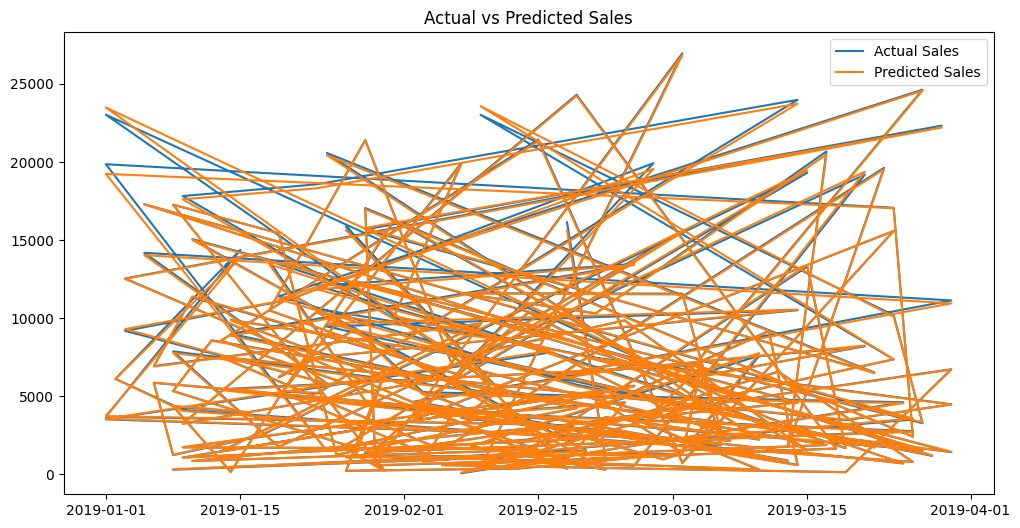

In [13]:
# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size:], y_test_original, label='Actual Sales')
plt.plot(data.index[train_size:], y_pred_test_original, label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

### 8.2 Scatter Plot
- Plot actual vs predicted sales as a scatter plot.

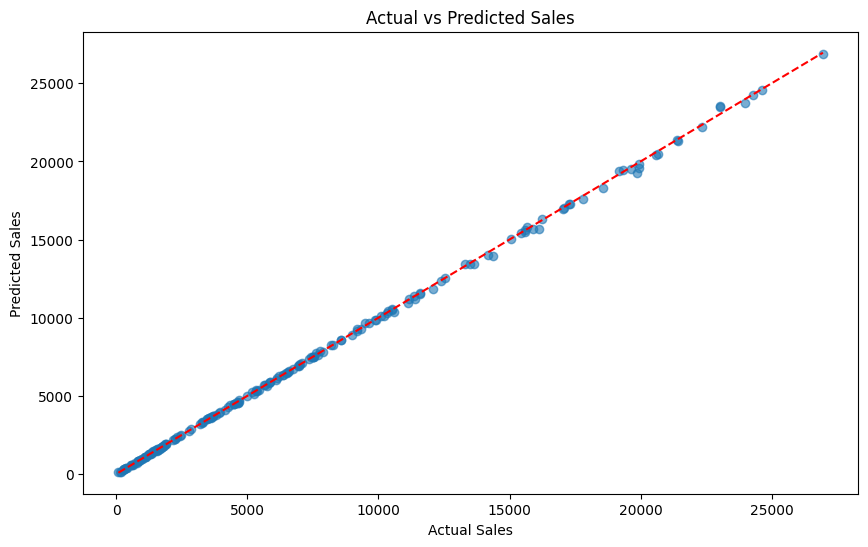

In [14]:
# Actual vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_test_original, alpha=0.6)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()